# USID and Dask.distributed

Authors: **Emily Costa, Suhas Somnath**

Created on: 7/30/19

This document will demonstrate how Dask.distributed can be used with USID files managed with pyUSID. We will then proceed to plot the performance benchmarks between the parallel_compute(), dask.distributed, and serial computation.


Prepare the modules:

In [4]:
from __future__ import division, print_function, absolute_import, unicode_literals

# The package for accessing files in directories, etc.:
import os

# Warning package in case something goes wrong
from warnings import warn
import subprocess
#from dask.diagnostics import Profiler, ResourceProfiler, visualize
import dask.array as da


def install(package):
    subprocess.call([sys.executable, "-m", "pip", "install", package])
# Package for downloading online files:
try:
    # This package is not part of anaconda and may need to be installed.
    import wget
except ImportError:
    warn('wget not found.  Will install with pip.')
    import pip
    install(wget)
    import wget

# The mathematical computation package:
import numpy as np
import dask
from dask.distributed import Client, LocalCluster
import dask.array as da

# The package used for creating and manipulating HDF5 files:
import h5py

# Packages for plotting:
import matplotlib.pyplot as plt

# Parallel computation library:
try:
    import joblib
except ImportError:
    warn('joblib not found.  Will install with pip.')
    import pip
    install('joblib')
    import joblib

# Timing
import time

# A handy python utility that allows us to preconfigure parts of a function
from functools import partial

# Finally import pyUSID:
try:
    import pyUSID as usid
except ImportError:
    warn('pyUSID not found.  Will install with pip.')
    import pip
    install('pyUSID')
    import pyUSID as usid
    

# import the scientific function:
import sys
sys.path.append('./supporting_docs/')
from peak_finding import find_all_peaks

Find main dataset:

In [5]:
url = 'https://raw.githubusercontent.com/pycroscopy/pyUSID/master/data/BELine_0004.h5'
h5_path = 'temp.h5'
if os.path.exists(h5_path):
    os.remove(h5_path)
_ = wget.download(url, h5_path, bar=None)
    # Open the file in read-only mode
h5_file = h5py.File(h5_path, mode='r')
    # Get handle to the the raw data
h5_meas_grp = h5_file['Measurement_000']
    # Accessing the dataset of interest:
h5_main = usid.USIDataset(h5_meas_grp['Channel_000/Raw_Data'])
num_rows, num_cols = h5_main.pos_dim_sizes

Test the find_all_peaks function:

Text(0.5, 1.0, 'find_all_peaks found peaks at index: [71]')

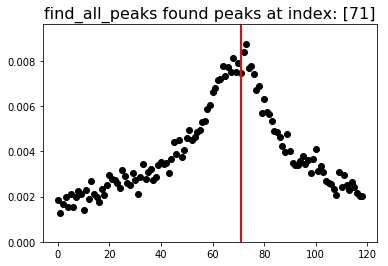

In [6]:
row_ind, col_ind = 110, 25
pixel_ind = col_ind + row_ind * num_cols
spectra = h5_main[pixel_ind]

peak_inds = find_all_peaks(spectra, [20, 60], num_steps=30)
    
fig, axis = plt.subplots()
axis.scatter(np.arange(len(spectra)), np.abs(spectra), c='black')
axis.axvline(peak_inds[0], color='r', linewidth=2)
axis.set_ylim([0, 1.1 * np.max(np.abs(spectra))]);
axis.set_title('find_all_peaks found peaks at index: {}'.format(peak_inds), fontsize=16)

The following cell demonstrates the ineffectiveness of serial computation in this example.
Compute serially:

In [7]:
start = time.time()
raw_data = h5_main[()]
serial_results = list()
for vector in raw_data:
    serial_results.append(find_all_peaks(vector, [20, 60], num_steps=30))
time_serial = time.time()-start
core_serial = 1


Compute using pyUSID parallel_compute() function:

In [ ]:
start = time.time()
raw_data = h5_main[()]
args = [[20, 60]]
kwargs = {'num_steps': 30}
cores = 3
parallel_results = usid.parallel_compute(raw_data, find_all_peaks, cores=cores, 
                                         func_args=args, func_kwargs=kwargs)
time_parallel = time.time() - start
cores_parallel = cores

Compute using Dask to automate:

In [ ]:
start = time.time()
raw_data = h5_main[()]
args = [[20, 60]]
kwargs = {'num_steps': 30}
### Do not convert numpy array to dask array for computation:
# dask_raw_data = da.from_array(raw_data, chunks='auto')
client = Client(processes=False)
dask_raw_data = client.scatter(raw_data)
L = client.submit(find_all_peaks, dask_raw_data, args, kwargs)
dask_results = client.compute(L)
cores_dask = client.ncores()
client.close()
time_dask = time.time() - start

Plot benchmarks:

In [ ]:
fig, axis = plt.subplots(figsize=(3.5, 3.5))
axis.scatter(core_serial, time_serial, c='blue')
axis.scatter(cores_parallel, time_parallel, c='green')
axis.scatter(cores_dask, time_dask, c='red')
axis.set_xlabel('CPU cores', fontsize=14)
axis.set_ylabel('Compute time (sec)', fontsize=14)
plt.legend()
fig.tight_layout()
plt.savefig('{}.png'.format(png_name))